## Limits of simple regression
#### Regression and causation

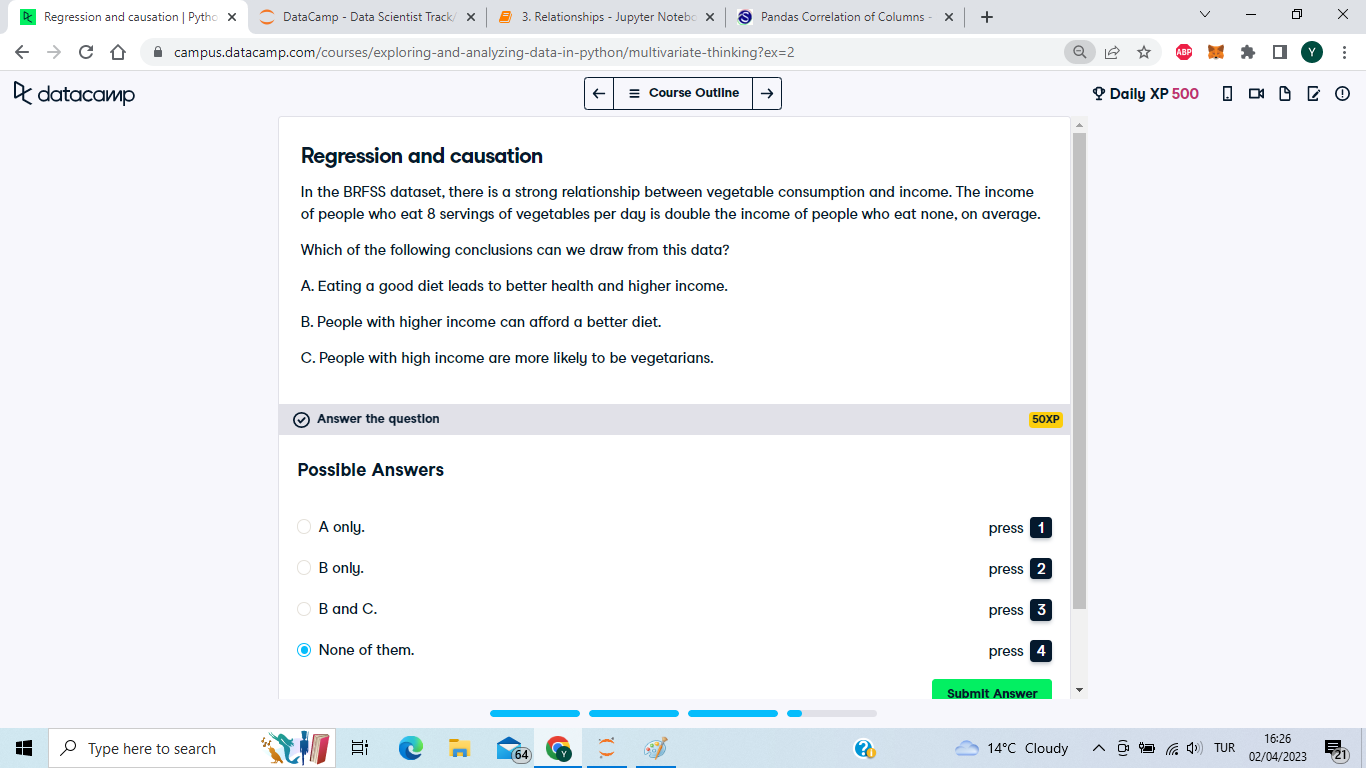

That's right. This data is consistent with all of these conclusions, but it does not provide conclusive evidence for any of them.

#### Using StatsModels
Let's run the same regression using SciPy and StatsModels, and confirm we get the same results.

In [3]:
from scipy.stats import linregress
import statsmodels.formula.api as smf
import pandas as pd

brfss = pd.read_hdf("brfss.hdf5")

# Run regression with linregress
subset = brfss.dropna(subset=['INCOME2', '_VEGESU1'])
xs = subset['INCOME2']
ys = subset['_VEGESU1']
res = linregress(xs, ys)
print(res,"\n\n")

# Run regression with StatsModels
results = smf.ols('_VEGESU1 ~ INCOME2', data = brfss).fit()
print(results.params)

LinregressResult(slope=0.0698804809210502, intercept=1.5287786243363106, rvalue=0.11967005884864103, pvalue=1.3785039162482424e-238, stderr=0.0021109763563323335, intercept_stderr=0.013196467544093609) 


Intercept    1.528779
INCOME2      0.069880
dtype: float64


Nice job. When you start working with a new library, checks like this help ensure that you are doing it right.

## Multiple regression
#### Plot income and education
To get a closer look at the relationship between income and education, let's use the variable 'educ' to group the data, then plot mean income in each group.

Here, the GSS dataset has been pre-loaded into a DataFrame called gss.

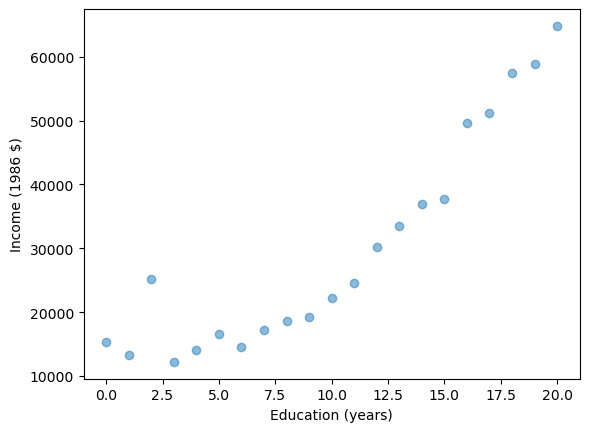

In [4]:
import matplotlib.pyplot as plt
gss = pd.read_hdf("gss.hdf5")

# Group by educ
grouped = gss.groupby("educ")

# Compute mean income in each group
mean_income_by_educ = grouped["realinc"].mean()

# Plot mean income as a scatter plot
plt.plot(mean_income_by_educ, 'o', alpha = 0.5)

# Label the axes
plt.xlabel('Education (years)')
plt.ylabel('Income (1986 $)')
plt.show()

Well done. It looks like the relationship between income and education is non-linear.

#### Non-linear model of education
The graph in the previous exercise suggests that the relationship between income and education is non-linear. So let's try fitting a non-linear model.

In [9]:
gss

,year,age,cohort,sex,race,educ,realinc,gunlaw,grass,wtssall
0,1972,26.0,1946.0,1,1,18.0,13537.0,2.0,NaN,0.889300
1,1972,38.0,1934.0,2,1,12.0,18951.0,1.0,NaN,0.444600
2,1972,57.0,1915.0,1,1,12.0,30458.0,1.0,NaN,1.333900
3,1972,61.0,1911.0,2,1,14.0,37226.0,1.0,NaN,0.889300
4,1972,59.0,1913.0,1,1,12.0,30458.0,2.0,NaN,0.889300
...,...,...,...,...,...,...,...,...,...,...
62461,2016,32.0,1984.0,1,1,13.0,74880.0,1.0,NaN,0.956994
62462,2016,61.0,1955.0,2,1,16.0,65520.0,NaN,1.0,0.956994
62463,2016,67.0,1949.0,2,1,13.0,NaN,NaN,2.0,1.564363
62464,2016,57.0,1959.0,2,1,12.0,9945.0,2.0,NaN,0.956994


In [11]:
import statsmodels.formula.api as smf

# Add a new column with educ squared
gss['educ2'] = gss["educ"]**2
gss["age2"] = gss["age"]**2

# Run a regression model with educ, educ2, age, and age2
results = smf.ols("realinc ~ educ + educ2 + age + age2", data = gss).fit()

# Print the estimated parameters
print(results.params)

Intercept   -23241.884034
educ          -528.309369
educ2          159.966740
age           1696.717149
age2           -17.196984
dtype: float64


Excellent. The slope associated with educ2 is positive, so the model curves upward.

## Visualizing regression results
#### Making predictions
At this point, we have a model that predicts income using age, education, and sex.

Let's see what it predicts for different levels of education, holding age constant.

In [15]:
import numpy as np

# Run a regression model with educ, educ2, age, and age2
results = smf.ols('realinc ~ educ + educ2 + age + age2', data=gss).fit()

# Make the DataFrame
df = pd.DataFrame()
df['educ'] = np.linspace(0, 20)
df['age'] = 30
df['educ2'] = df['educ']**2
df['age2'] = df['age']**2

# Generate and plot the predictions
pred = results.predict(df)
print(pred[:30])

0     12182.344976
1     11993.358518
2     11857.672098
3     11775.285717
4     11746.199374
5     11770.413069
6     11847.926802
7     11978.740574
8     12162.854384
9     12400.268232
10    12690.982118
11    13034.996043
12    13432.310006
13    13882.924007
14    14386.838046
15    14944.052124
16    15554.566240
17    16218.380394
18    16935.494586
19    17705.908817
20    18529.623086
21    19406.637393
22    20336.951738
23    21320.566122
24    22357.480544
25    23447.695004
26    24591.209502
27    25788.024039
28    27038.138614
29    28341.553227
dtype: float64


Nice job. Now let's see what the results look like.

#### Visualizing predictions
Now let's visualize the results from the previous exercise!

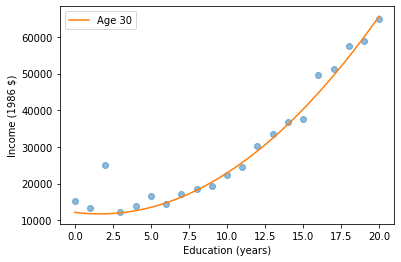

In [16]:
# Plot mean income in each age group
plt.clf()
grouped = gss.groupby('educ')
mean_income_by_educ = grouped['realinc'].mean()
plt.plot(mean_income_by_educ, 'o', alpha = 0.5)

# Plot the predictions
pred = results.predict(df)
plt.plot(df['educ'], pred, label='Age 30')

# Label axes
plt.xlabel('Education (years)')
plt.ylabel('Income (1986 $)')
plt.legend()
plt.show()

Looks like this model captures the relationship pretty well. Nice job.

## Logistic regression
#### Predicting a binary variable
Let's use logistic regression to predict a binary variable. Specifically, we'll use age, sex, and education level to predict support for legalizing cannabis (marijuana) in the U.S.

In the GSS dataset, the variable grass records the answer to the question "Do you think the use of marijuana should be made legal or not?"

In [17]:
# Recode grass
gss['grass'].replace(2, 0, inplace=True)

# Run logistic regression
results = smf.logit("grass~age+age2+educ+educ2+sex",data = gss).fit()
results.params

Optimization terminated successfully.
         Current function value: 0.588510
         Iterations 6


Intercept   -1.300612
age         -0.034756
age2         0.000192
educ         0.221860
educ2       -0.004163
sex         -0.384611
dtype: float64

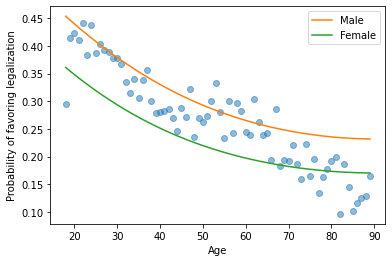

In [20]:
# Make a DataFrame with a range of ages
df = pd.DataFrame()
df['age'] = np.linspace(18, 89)
df['age2'] = df['age']**2

# Set the education level to 12
df['educ'] = 12
df['educ2'] = df['educ']**2

# Generate predictions for men and women
df['sex'] = 1
pred1 = results.predict(df)

df['sex'] = 2
pred2 = results.predict(df)

plt.clf()
grouped = gss.groupby('age')
favor_by_age = grouped["grass"].mean()
plt.plot(favor_by_age, 'o', alpha=0.5)

plt.plot(df['age'], pred1, label='Male')
plt.plot(df['age'], pred2, label = "Female")

plt.xlabel('Age')
plt.ylabel('Probability of favoring legalization')
plt.legend()
plt.show()

You made it! Congratulations on completing this course. I hope you enjoyed it and learned a lot. Should you wish to use the Pmf and Cdf classes from this course in your own work, you can download the empiricaldist library here.